In [1]:
import pandas as pd 
import os 
import cv2
from PIL import Image
import numpy as np
import glob

In [2]:
def load_img(path, img_size = 128,classes = ['Apis mellifera', 'Bombus terrestris']): 
    """
    Load image from a folder named after the species

    Parameters
    ----------
    path : str
        Path to the folder containing the images, folder name is the species name
    img_size : int
        Size of the image
    classes : list
        List of the species to load

    Returns
    -------
        x,y : arrays
    """

    # Get the list of all the files in directory
    file_path = []

    for root, dirs, files in os.walk(path):

        for f in files:
            fullpath = os.path.join(root, f)
            file_path.append(fullpath)


    # initialize the arrays
    x = np.zeros((len(file_path),img_size,img_size, 3))
    y = np.zeros((len(file_path),1))

    # loop over the input images
    for i, file in enumerate(file_path):

        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(file)
        image = cv2.resize(image, (img_size,img_size),Image.ANTIALIAS)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image =np.asarray(image)
        x[i] = image

        # extract the class label from the image path and update the
        # labels list
        label = file.split(os.path.sep)[-2]
        # returns 0 or 1
        index  = classes.index(label)
        # convert to numpy array
        y[i] = int(index)

    return x,y

In [3]:
path = "/workspaces/projet_bees_detection_basile/data_bees_detection/benchmark_classification/1_VGG_16_300_imgs_2_species"
path = "workspaces/projet_bees_detection_basile/data_bees_detection/benchmark_classification/1_VGG_16_300_imgs_2_species"
list = ['train', 'test', 'validation']
CLASSES = ['Apis mellifera', 'Bombus terrestris']

paths = [os.path.join(path, i) for i in list]

x_train, y_train = load_img(paths[0] )
x_test, y_test = load_img(paths[1] )
x_val, y_val = load_img(paths[2] )

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255


In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((0, 128, 128, 3), (0, 1), (0, 128, 128, 3), (0, 1), (0, 128, 128, 3), (0, 1))

In [5]:
x_train[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

Print some pictures 


IndexError: index 0 is out of bounds for axis 0 with size 0

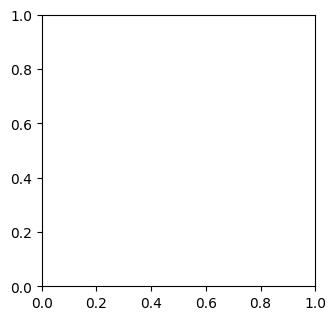

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Randomisation des indices et affichage de 9 images alétoires de la base d'apprentissage
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.title(CLASSES[int(y_train[i])])
    plt.imshow(x_train[i])
plt.tight_layout()
plt.show()

Implement simple VGG model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential

# On charge le modèle VGG16 pré-entraîné sur ImageNet et sans les couches fully-connected
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# On freeze les poids des couches convolutionnelles
for layer in vgg16_model.layers:
    layer.trainable = False

# On ajoute les couches fully-connected pour la classification à 2 classes
from keras.layers import Flatten, Dense

model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# On compile le modèle
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])


2023-06-05 15:21:00.016439: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 15:21:00.120357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 15:21:03.857880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-05 15:21:03.876231: I tensorflow/comp

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [ ]:
# clear gpu memory
from keras import backend as K
K.clear_session()


In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


2023-05-25 15:39:08.304854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-05-25 15:39:08.821214: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-25 15:39:10.193225: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 15:39:10.193404: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 15:39:11.484086: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate

14/14 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.5690

2023-05-25 15:39:18.399164: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.85GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 15:39:18.399194: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.85GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 15:39:19.473627: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 15:39:19.473654: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

14/14 [==============================] - 14s 585ms/step - loss: 0.6656 - accuracy: 0.5690 - val_loss: 0.6336 - val_accuracy: 0.6556
Epoch 2/10
14/14 [==============================] - 2s 124ms/step - loss: 0.4895 - accuracy: 0.7833 - val_loss: 0.6596 - val_accuracy: 0.5667
Epoch 3/10
14/14 [==============================] - 2s 125ms/step - loss: 0.4138 - accuracy: 0.8310 - val_loss: 0.5861 - val_accuracy: 0.7222
Epoch 4/10
14/14 [==============================] - 2s 125ms/step - loss: 0.3549 - accuracy: 0.8881 - val_loss: 0.5697 - val_accuracy: 0.7222
Epoch 5/10
14/14 [==============================] - 2s 125ms/step - loss: 0.3038 - accuracy: 0.9071 - val_loss: 0.5808 - val_accuracy: 0.7000
Epoch 6/10
14/14 [==============================] - 2s 125ms/step - loss: 0.2776 - accuracy: 0.9048 - val_loss: 0.5742 - val_accuracy: 0.7000
Epoch 7/10
14/14 [==============================] - 2s 125ms/step - loss: 0.2270 - accuracy: 0.9690 - val_loss: 0.5521 - val_accuracy: 0.7333
Epoch 8/10
14/14

In [ ]:
# plot history 

def plot_history(history,metric): 

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

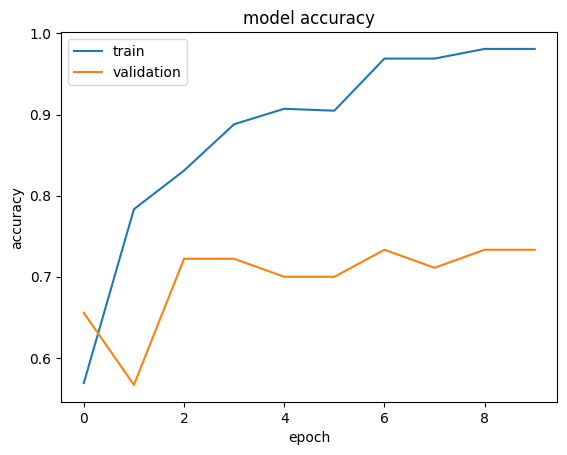

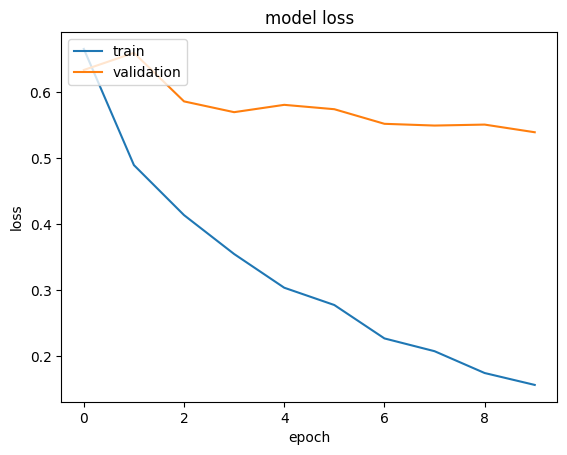

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')

We are clearly facing some overfitting, to prevent it we will add augmentations


In [ ]:
# import augmentation
from keras.preprocessing.image import ImageDataGenerator

# On crée un générateur d'images en utilisant les données d'entraînement
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=10, validation_data=(x_val, y_val))

2023-05-25 19:28:42.214639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 19:28:42.369403: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 19:28:43.066377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/basile/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-25 19:28:43.066446: W te

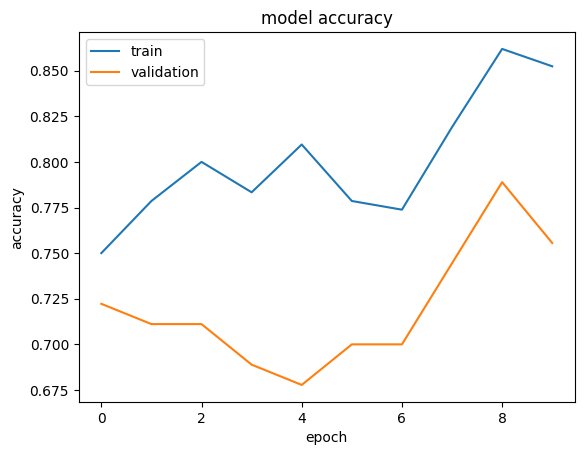

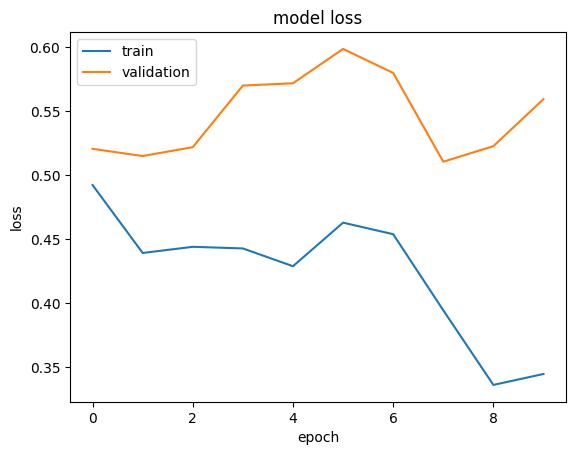

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')

It is better, yer Doesnt seem to have reach a minimum, we'll add some more epochs

In [ ]:
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=40, validation_data=(x_val, y_val))

Epoch 1/40


/tmp/ipykernel_7685/843854644.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=40, validation_data=(x_val, y_val))


14/14 [==============================] - 2s 125ms/step - loss: 0.3700 - accuracy: 0.8381 - val_loss: 0.5194 - val_accuracy: 0.7222
Epoch 2/40
14/14 [==============================] - 2s 123ms/step - loss: 0.3654 - accuracy: 0.8214 - val_loss: 0.5118 - val_accuracy: 0.7444
Epoch 3/40
14/14 [==============================] - 2s 123ms/step - loss: 0.3136 - accuracy: 0.8619 - val_loss: 0.5197 - val_accuracy: 0.7778
Epoch 4/40
14/14 [==============================] - 2s 132ms/step - loss: 0.3625 - accuracy: 0.8310 - val_loss: 0.5325 - val_accuracy: 0.7667
Epoch 5/40
14/14 [==============================] - 2s 125ms/step - loss: 0.3632 - accuracy: 0.8500 - val_loss: 0.5505 - val_accuracy: 0.7333
Epoch 6/40
14/14 [==============================] - 2s 124ms/step - loss: 0.2942 - accuracy: 0.8833 - val_loss: 0.5890 - val_accuracy: 0.7333
Epoch 7/40
14/14 [==============================] - 2s 125ms/step - loss: 0.2827 - accuracy: 0.8881 - val_loss: 0.5426 - val_accuracy: 0.7667
Epoch 8/40
14/14 

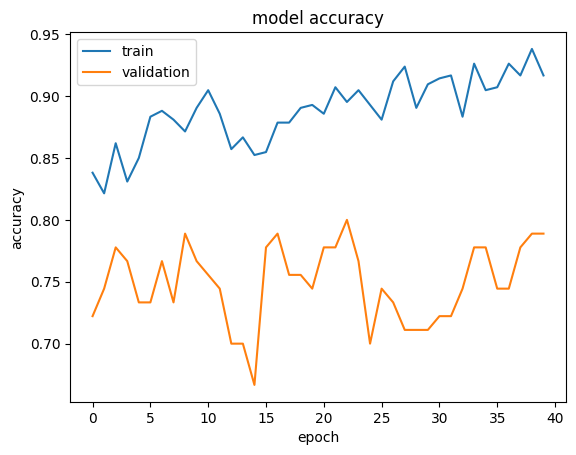

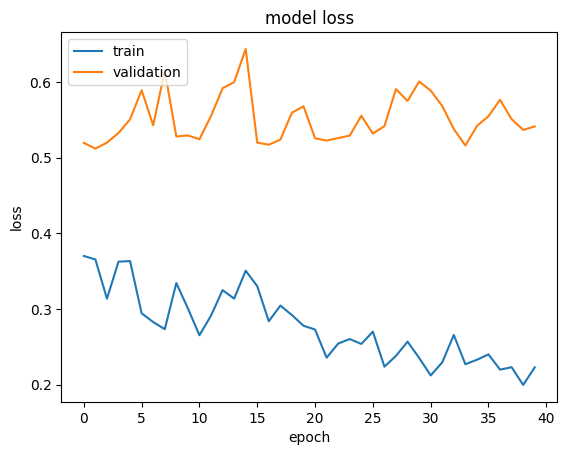

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')


Val accuracy reaches a better score like this , we'll try to add some more epoxhs just to see the long run behavior of the curves

In [ ]:
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=80, validation_data=(x_val, y_val))

Epoch 1/80


/tmp/ipykernel_7685/722585285.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=80, validation_data=(x_val, y_val))


14/14 [==============================] - 2s 126ms/step - loss: 0.1885 - accuracy: 0.9310 - val_loss: 0.5406 - val_accuracy: 0.7667
Epoch 2/80
14/14 [==============================] - 2s 123ms/step - loss: 0.2031 - accuracy: 0.9214 - val_loss: 0.5531 - val_accuracy: 0.7333
Epoch 3/80
14/14 [==============================] - 2s 124ms/step - loss: 0.2225 - accuracy: 0.9214 - val_loss: 0.5612 - val_accuracy: 0.7222
Epoch 4/80
14/14 [==============================] - 2s 124ms/step - loss: 0.2279 - accuracy: 0.9167 - val_loss: 0.6183 - val_accuracy: 0.7222
Epoch 5/80
14/14 [==============================] - 2s 124ms/step - loss: 0.2042 - accuracy: 0.9333 - val_loss: 0.6020 - val_accuracy: 0.7667
Epoch 6/80
14/14 [==============================] - 2s 124ms/step - loss: 0.2373 - accuracy: 0.9048 - val_loss: 0.6380 - val_accuracy: 0.7000
Epoch 7/80
14/14 [==============================] - 2s 125ms/step - loss: 0.2550 - accuracy: 0.8976 - val_loss: 0.5402 - val_accuracy: 0.7778
Epoch 8/80
14/14 

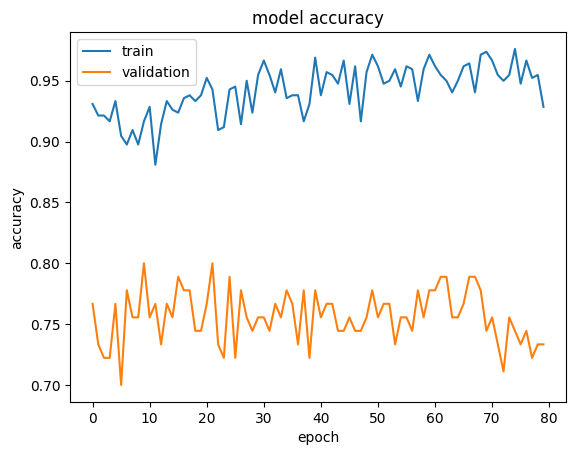

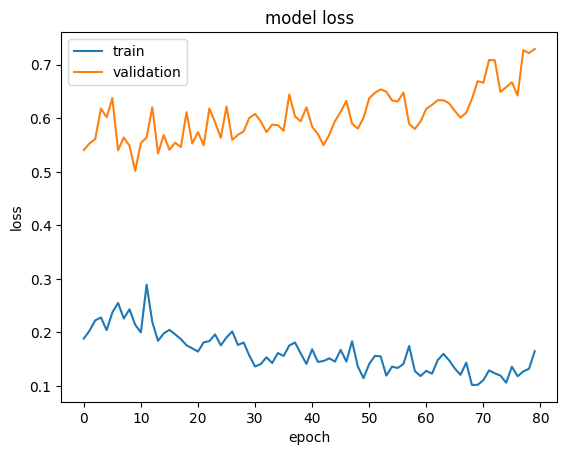

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')

We are, clearly overfitting from epoch 10
\n Val accuracy seems to reach a maximum at 0.8, we'll put some checkpoints to try keeping optimising the parameters that led to this score

In [ ]:
# callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
weight_path=os.path.join(path,'model.h5')
callbacks = [ModelCheckpoint(filepath=weight_path, monitor='val_accuracy', save_best_only=True,reload_best_only=True)]

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=30, validation_data=(x_val, y_val),callbacks=callbacks)

Epoch 1/30


/tmp/ipykernel_7685/2162961016.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=30, validation_data=(x_val, y_val),callbacks=callbacks)


14/14 [==============================] - 2s 135ms/step - loss: 0.0924 - accuracy: 0.9762 - val_loss: 0.7138 - val_accuracy: 0.7667
Epoch 2/30
14/14 [==============================] - 2s 135ms/step - loss: 0.0767 - accuracy: 0.9881 - val_loss: 0.7019 - val_accuracy: 0.7778
Epoch 3/30
14/14 [==============================] - 2s 134ms/step - loss: 0.1091 - accuracy: 0.9643 - val_loss: 0.6982 - val_accuracy: 0.7889
Epoch 4/30
14/14 [==============================] - 2s 125ms/step - loss: 0.1107 - accuracy: 0.9690 - val_loss: 0.7282 - val_accuracy: 0.7556
Epoch 5/30
14/14 [==============================] - 2s 127ms/step - loss: 0.1166 - accuracy: 0.9548 - val_loss: 0.7119 - val_accuracy: 0.7778
Epoch 6/30
14/14 [==============================] - 2s 126ms/step - loss: 0.0741 - accuracy: 0.9881 - val_loss: 0.6800 - val_accuracy: 0.7667
Epoch 7/30
14/14 [==============================] - 2s 126ms/step - loss: 0.0673 - accuracy: 0.9881 - val_loss: 0.6832 - val_accuracy: 0.7778
Epoch 8/30
14/14 

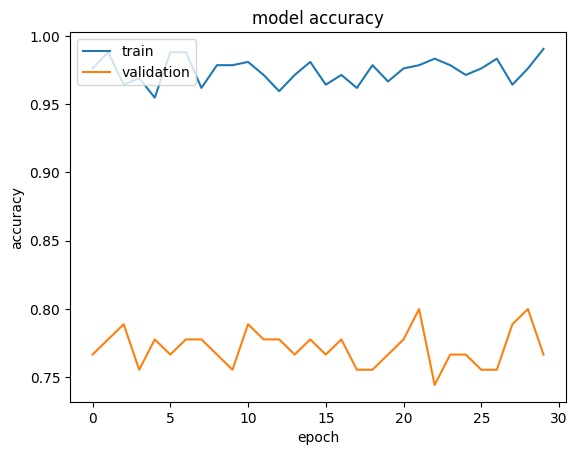

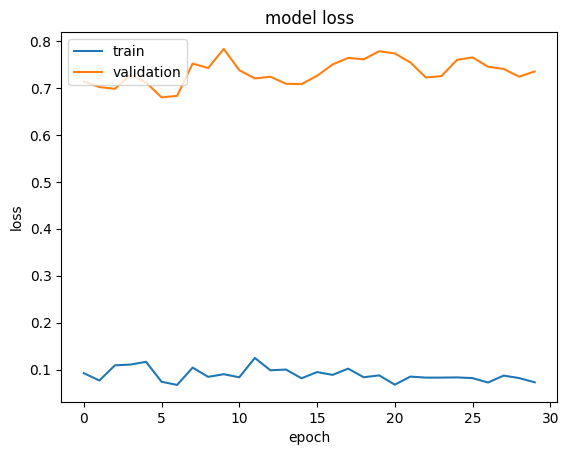

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')


Doesnt seem to have that much effect, we'll try to fine tune the conv base 

In [ ]:
# set the conv layers to be trainable
for layer in model.layers[0].layers:
    layer.trainable = True

# On compile le modèle
from keras.optimizers import Adam
# small learning rate to avoid divergence
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

/home/basile/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.summary(show_trainable=True) 

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  Y          
                                                                            
 flatten (Flatten)           (None, 8192)              0         Y          
                                                                            
 dense (Dense)               (None, 256)               2097408   Y          
                                                                            
 dense_1 (Dense)             (None, 1)                 257       Y          
                                                                            
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
____________________________________________________________________________


In [ ]:
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=30, validation_data=(x_val, y_val),callbacks=callbacks)

Epoch 1/30


/tmp/ipykernel_7685/1019956495.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=30, validation_data=(x_val, y_val),callbacks=callbacks)


14/14 [==============================] - 10s 406ms/step - loss: 0.1533 - accuracy: 0.9286 - val_loss: 0.7830 - val_accuracy: 0.7667
Epoch 2/30
14/14 [==============================] - 4s 314ms/step - loss: 0.0888 - accuracy: 0.9595 - val_loss: 0.7901 - val_accuracy: 0.7556
Epoch 3/30
14/14 [==============================] - 4s 315ms/step - loss: 0.0925 - accuracy: 0.9714 - val_loss: 0.8323 - val_accuracy: 0.7222
Epoch 4/30
14/14 [==============================] - 4s 333ms/step - loss: 0.0775 - accuracy: 0.9667 - val_loss: 0.8399 - val_accuracy: 0.7222
Epoch 5/30
14/14 [==============================] - 4s 317ms/step - loss: 0.0623 - accuracy: 0.9786 - val_loss: 0.9199 - val_accuracy: 0.7111
Epoch 6/30
14/14 [==============================] - 4s 316ms/step - loss: 0.0783 - accuracy: 0.9833 - val_loss: 0.9330 - val_accuracy: 0.7333
Epoch 7/30
14/14 [==============================] - 4s 318ms/step - loss: 0.0583 - accuracy: 0.9810 - val_loss: 0.7903 - val_accuracy: 0.7667
Epoch 8/30
14/14

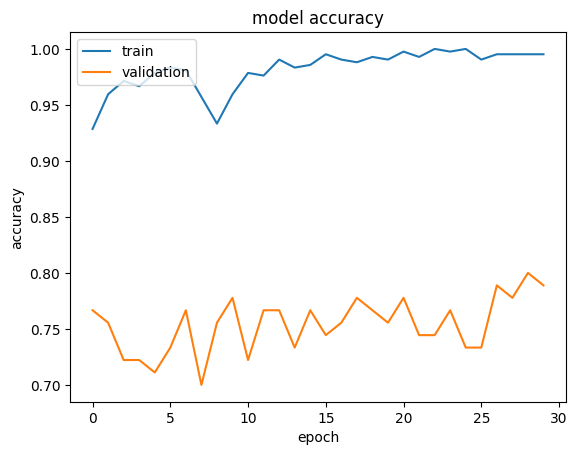

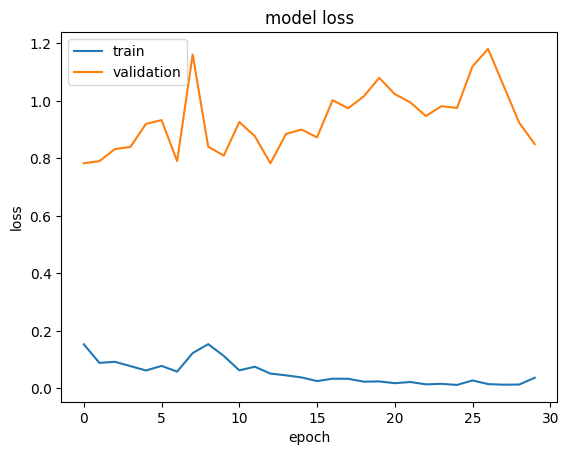

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')


We'll put some regularisation

In [ ]:
# add dropout and Elasticnet regularization
from keras.regularizers import l1_l2
from keras.layers import Dropout

model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# On compile le modèle
from keras.optimizers import Adam
# small learning rate to avoid divergence
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])




history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=30, validation_data=(x_val, y_val),callbacks=callbacks)

Epoch 1/30


/home/basile/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_7685/395627513.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=30, validation_data=(x_val, y_val),callbacks=callbacks)


14/14 [==============================] - 5s 314ms/step - loss: 29.1388 - accuracy: 0.4929 - val_loss: 28.9198 - val_accuracy: 0.5667
Epoch 2/30
14/14 [==============================] - 4s 309ms/step - loss: 28.8512 - accuracy: 0.5548 - val_loss: 28.6855 - val_accuracy: 0.6000
Epoch 3/30
14/14 [==============================] - 4s 310ms/step - loss: 28.5660 - accuracy: 0.6167 - val_loss: 28.4508 - val_accuracy: 0.6000
Epoch 4/30
14/14 [==============================] - 4s 312ms/step - loss: 28.3457 - accuracy: 0.6429 - val_loss: 28.1909 - val_accuracy: 0.7000
Epoch 5/30
14/14 [==============================] - 4s 314ms/step - loss: 28.0862 - accuracy: 0.6857 - val_loss: 27.9407 - val_accuracy: 0.7111
Epoch 6/30
14/14 [==============================] - 4s 315ms/step - loss: 27.8108 - accuracy: 0.7429 - val_loss: 27.7150 - val_accuracy: 0.7556
Epoch 7/30
14/14 [==============================] - 4s 315ms/step - loss: 27.5585 - accuracy: 0.8143 - val_loss: 27.4783 - val_accuracy: 0.7778
Epo

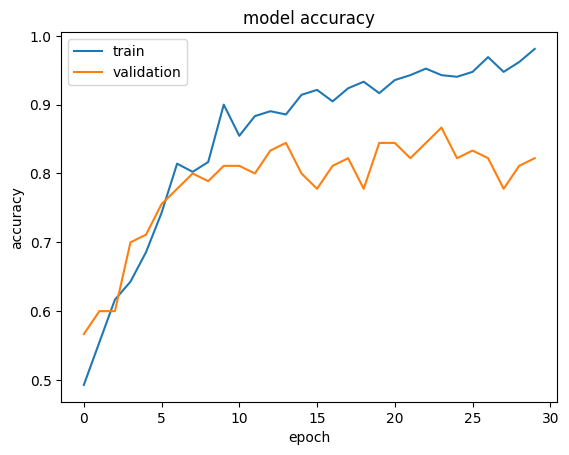

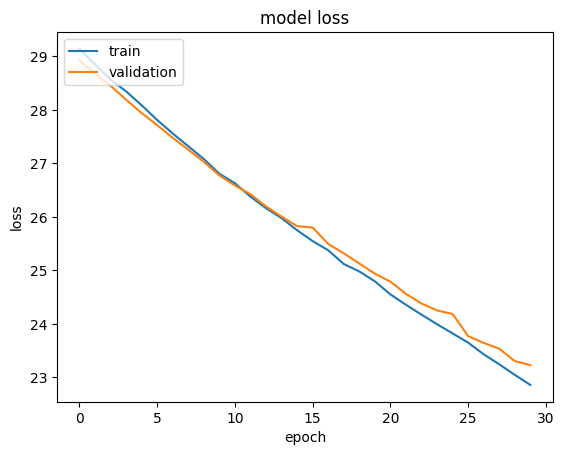

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')

Network seems to perform slightly better with this approach, with val_accuracy reaching 86%
\n we'll try to add some more epochs to see the long run behavior

In [ ]:
callbacks = [ModelCheckpoint(filepath=weight_path, monitor='val_accuracy', save_best_only=True)]

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=80, validation_data=(x_val, y_val),callbacks=callbacks)

Epoch 1/80


/tmp/ipykernel_7685/133442404.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=80, validation_data=(x_val, y_val),callbacks=callbacks)


14/14 [==============================] - 5s 335ms/step - loss: 22.6940 - accuracy: 0.9667 - val_loss: 23.0439 - val_accuracy: 0.8222
Epoch 2/80
14/14 [==============================] - 4s 310ms/step - loss: 22.4857 - accuracy: 0.9786 - val_loss: 22.9530 - val_accuracy: 0.8222
Epoch 3/80
14/14 [==============================] - 4s 312ms/step - loss: 22.3173 - accuracy: 0.9786 - val_loss: 22.7983 - val_accuracy: 0.7778
Epoch 4/80
14/14 [==============================] - 4s 314ms/step - loss: 22.1488 - accuracy: 0.9714 - val_loss: 22.5859 - val_accuracy: 0.8000
Epoch 5/80
14/14 [==============================] - 5s 316ms/step - loss: 21.9765 - accuracy: 0.9714 - val_loss: 22.3615 - val_accuracy: 0.7889
Epoch 6/80
14/14 [==============================] - 4s 315ms/step - loss: 21.8772 - accuracy: 0.9238 - val_loss: 22.2796 - val_accuracy: 0.7444
Epoch 7/80
14/14 [==============================] - 4s 317ms/step - loss: 21.6369 - accuracy: 0.9762 - val_loss: 21.9790 - val_accuracy: 0.7778
Epo

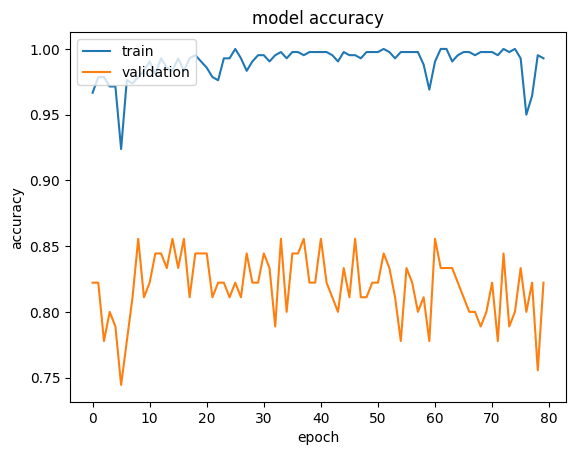

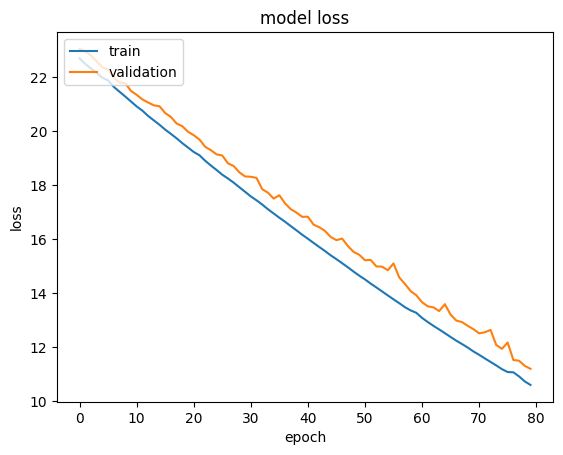

In [ ]:
plot_history(history,'accuracy')
plot_history(history,'loss')


We will try to augment scores with larger images

In [ ]:
path = "/workspaces/projet_bees_detection_basile/data_bees_detection/benchmark_classification/1_VGG_16_300_imgs_2_species"
list = ['train', 'test', 'validation']
CLASSES = ['Apis mellifera', 'Bombus terrestris']

paths = [os.path.join(path, i) for i in list]

x_train, y_train = load_img(paths[0],img_size=256)
x_test, y_test = load_img(paths[1],img_size=256) 
x_val, y_val = load_img(paths[2],img_size=256)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

In [ ]:
# Create model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.regularizers import l1_l2
from keras.applications.vgg16 import VGG16

# On charge le modèle VGG16 pré-entraîné sur ImageNet et sans les couches fully-connected
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# On compile le modèle
from keras.optimizers import Adam
# small learning rate to avoid divergence
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])


# callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

weight_path=os.path.join(path,'model.h5')
callbacks = [ModelCheckpoint(filepath=weight_path, monitor='val_accuracy', save_best_only=True,reload_best_only=True)]

2023-05-25 19:29:30.801539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 19:29:30.816703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 19:29:30.816859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


KeyboardInterrupt: 

In [ ]:
model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  Y          
                                                                            
 flatten (Flatten)           (None, 32768)             0         Y          
                                                                            
 dense (Dense)               (None, 256)               8388864   Y          
                                                                            
 dropout (Dropout)           (None, 256)               0         Y          
                                                                            
 dense_1 (Dense)             (None, 1)                 257       Y          
                                                                            
Total params: 23,103,809
Trainable params: 23,103,809
No

In [ ]:
# train the model

model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=50, validation_data=(x_val, y_val),callbacks=callbacks)

/tmp/ipykernel_6789/1113481397.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=50, validation_data=(x_val, y_val),callbacks=callbacks)


Epoch 1/50


2023-05-25 16:39:56.671478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-05-25 16:39:57.176333: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-25 16:39:57.513399: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 16:39:57.513943: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 16:40:01.282636: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/vgg16/block3_pool/MaxPool' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/basile/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/basile/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_6789/1113481397.py", line 3, in <module>
      model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),epochs=50, validation_data=(x_val, y_val),callbacks=callbacks)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2604, in fit_generator
      return self.fit(
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/layers/pooling/base_pooling2d.py", line 84, in call
      outputs = self.pool_function(
Node: 'sequential/vgg16/block3_pool/MaxPool'
OOM when allocating tensor with shape[32,256,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/vgg16/block3_pool/MaxPool}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2201]